# Implement HiTS-EQ in python - both Equation and curve fitting solutions
Hsuan-Chun Lin 2023.03
This is the python version of my research, HiTS-EQ. Since I have implement it in R in 2015, but there is still inconvenience in that 2015 version. Therefore I have decided to implement HiTS-EQ method, both fitting and equation to python.

There are the improvements from my 2015 R version.

- Multiple binding fractions are support: before in my R version, once we change the number of binding fractions, e.g. from 4 data points to 6 data points, we need to modify the code to adapt the change. Now in this python version by using Pandas, we don't need to do so. Just import your data in the correct format and enjoy the convenience.
- Interactive scatter plot is added to make sure we can quick galance the binding of **each** sequence by **plotly**.
- Multiple filters are added to make sure we can monitor the data and fitting quality.
- Jupyter notebook is provided in order to monitor the process of each step and the source code is more readable.

If this implementation is useful to you, please cite

```
@software{HiTS-EQ_python_HCL 2023,
  author = {Hsuan-Chun Lin},
  month = {03},
  title = {{HiTS-EQ python implementation}},
  url = {},
  version = {1.0.1},
  year = {2023}
}
```
## Import necessary packages

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from functools import partial
import seaborn as sns
import matplotlib.pylab as plt
import plotly.express as px

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Import data in csv format and fetch the binding fractions

In [2]:
filename_input = "input_data.csv"
df = pd.read_csv(filename_input, header=0)
df.head()

,Seq,1,2,3,4
0,f,0,0.25,0.5,0.75
1,[E],0,6.67,20.0,60.00
2,AAAAAA,4133,1425.00,1754.0,1422.00
3,AAAAAC,2662,1049.00,998.0,953.00
4,AAAAAG,5247,2726.00,2612.0,2322.00


## Curve Fitting Solution
### Set parameters
Set your reference row number. If your reference sequence locates at the 3rd row, please enter **2** because pyton starts from *0*.


In [3]:
ref_sequence = "AAAAAG"
ref_row_number = df[df.iloc[:,0] == ref_sequence].index[0] - 2
k_initial = 1
count_threshold = 400

### Data format preprocessing

In [4]:
#Extract enzyme concentrations
enzyme_concentration =  df.iloc[1,1:]

#Calculate binding fractions (1-f)
binding_fraction = 1 - df.iloc[0,1:].astype(float)

#Extract sequence counts and reset index
sequence_count = df.iloc[2:,1:]
library = df.iloc[2:,0].reset_index().drop("index",axis=1)

### Check the counts of the 0 point of each sequence
We want to make sure every sequence is amplified properly. Therefore every sequence with counts lower than threshold (set by you) will be labeled as **NG**, otherwise it will be **OK**.

In [5]:
def threshold_check(x):
    if x >= count_threshold:
        return "OK"
    else:
        return "NG"
qc = sequence_count.iloc[:,1].astype(float).apply(threshold_check).reset_index(drop=True).apply(pd.Series)

### Define fitting function
$$f = 1 -( \frac{D_{t}}{D_t1}\times (1-frac) \times \frac{D_1}{D_0})= \frac{E}{E+K_D}$$

In [6]:
#Calculate summation of sequence counts for each data point.
Dt_all = sequence_count.sum()
#Calculate Dt/Dt1
Dt_Dt1_all = Dt_all[0]/Dt_all
#Extract all the D0
D0_ = sequence_count.iloc[:,0]
#Calculate D1/D0
D1fD0 = sequence_count.divide(D0_,axis='rows')
#Create table for fitting
fitting_table = 1 - (Dt_Dt1_all * binding_fraction * D1fD0)
#Assign a very small random value for each value less than 0 in order to make sure the fitting can be performed well.
fitting_table[fitting_table < 0] = np.random.randint(1,9)/100000
#Reset the index of fitting table
fitting_table = fitting_table.reset_index()
fitting_table = fitting_table.drop("index",axis = 1)

### Define fitting equations and implement it by curve_fit and partial functions
Becuase we have calculated y, which is fitting table.
$$ y = 1 -( \frac{D_{t}}{D_t1}\times (1-frac) \times \frac{D_1}{D_0}) $$
Now we set a function
$$ y = \frac{x}{x+K} $$
Because our x will be the enzyme concentrations.

In [7]:
def HitsEQ(x, K):
    return x/(x+K)

def curvefit(func, x, y, k_initial):
    return tuple(curve_fit(func, x, y, p0=k_initial))

fit = partial(curvefit, HitsEQ, enzyme_concentration, k_initial=k_initial)
#Partial functions allow us to fix a certain number of arguments of a function and generate a new function.

### Fit your data and get results

In [8]:
#Fitting
K = fitting_table.apply(fit, axis=1).apply(pd.Series)

#Organize format
K.columns = ["K", "pcov"]
finalresult = K.explode(["K", "pcov"]).explode("pcov").reset_index(drop=True)
finalresult[["id"]] = library

#Convert Kd to Ka
finalresult[["KA"]] = (1/finalresult.K).apply(pd.Series)

#Calculate Ka to relative Ka
finalresult[["RKA"]] = (finalresult.KA/finalresult.KA[ref_row_number]).apply(pd.Series)
finalresult[["qc"]] = qc
#Rearrange the columns
cols = ['id', 'K', 'KA', 'RKA', 'pcov', 'qc']
finalresult = finalresult[cols]
#Make summary for pcov. You might use pcov to galance the fitting quality.
finalresult.pcov.astype(float).describe(percentiles=[.25, .5, .75],include=all)

count    4096.000000
mean       89.958320
std       402.304294
min         0.000045
25%         0.074850
50%         0.454456
75%         5.380268
max      4155.319521
Name: pcov, dtype: float64

## Use pcov to filter the fitting result. pcov roughly means the error
pcov will contain the true variance and covariance of the parameters. Because we only have one parameter, the range of K is
$$ K \pm \sqrt{pcov} $$

In [9]:
limit_pcov = 10000000
filter = finalresult[(finalresult.pcov < limit_pcov)]

### Visualize the fitting result by histogram

<Axes: xlabel='RKA', ylabel='Count'>

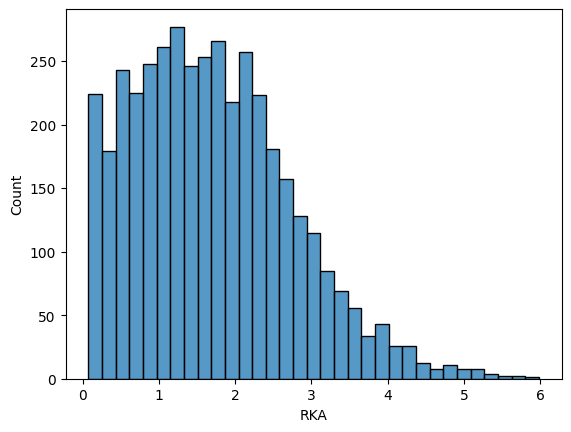

In [10]:
#Just plot rKa values
sns.histplot(filter.RKA)

<Axes: xlabel='RKA', ylabel='Count'>

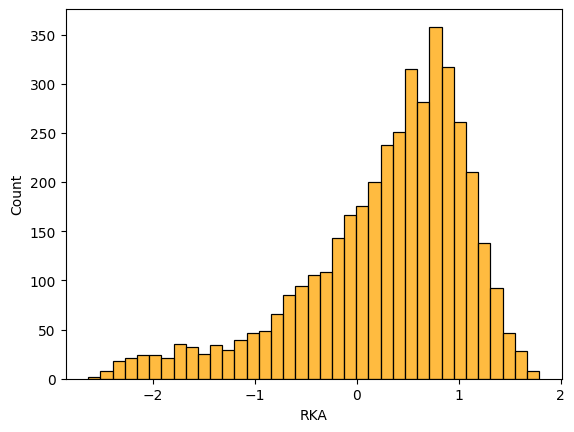

In [11]:
#Have nature log to indicate the gibbs energy
sns.histplot(np.log(filter.RKA.astype(float)), color = "orange")

## Equation solution - use unbound and one fraction point

$$ K_{2, rel} = \frac{E}{ \left( \frac{S_1}{S_2} \frac{S_{1,0}}{S_{2,0}}(1+E)\right)-1}$$

In [12]:
S1 = sequence_count.iloc[2,:] # Our reference sequence is "AAAAAG" therefore we set it to 2 because it is the third sequence of the table.
S10 = S1[0]
Step1 = 1/(sequence_count.divide(sequence_count.iloc[:,0], axis=0))
refs = S1/S1[0]
div_ = Step1 * refs * (1+enzyme_concentration) -1
rKd = enzyme_concentration/div_
RKA = 1/rKd
RKA = RKA.apply(pd.Series).reset_index()
RKA["id"] = library
RKA["qc"] = qc
RKA = RKA.drop("index", axis = 1)

## Compare the results from fitting method and the equation method
I highly recommend to use both methods to calculate your result. Maybe we can find some hidden messages from both method. They might be from RNA structures, abnormal amplification, etc.

In [13]:
choose_col = 7
plotdata = filter.merge(RKA, on="id", how='left')
plotdata.head()

,id,K,KA,RKA,pcov,qc_x,1,2,3,4,qc_y
0,AAAAAA,7.96889,0.125488,1.885934,2.596841,OK,NaN,1.582821,1.18165,1.290995,OK
1,AAAAAC,8.600381,0.116274,1.747457,0.477099,OK,NaN,1.366137,1.344212,1.240072,OK
2,AAAAAG,15.0288,0.066539,1.000000,0.144638,OK,NaN,1.0,1.0,1.0,OK
3,AAAAAT,6.204218,0.161181,2.422352,0.366085,OK,NaN,1.646104,1.582885,1.774441,OK
4,AAAACA,4.82366,0.207311,3.115642,0.054333,OK,NaN,1.83052,2.135988,2.060999,OK


Text(0.5, 2.6437119782515577, 'R-squared: 0.96')

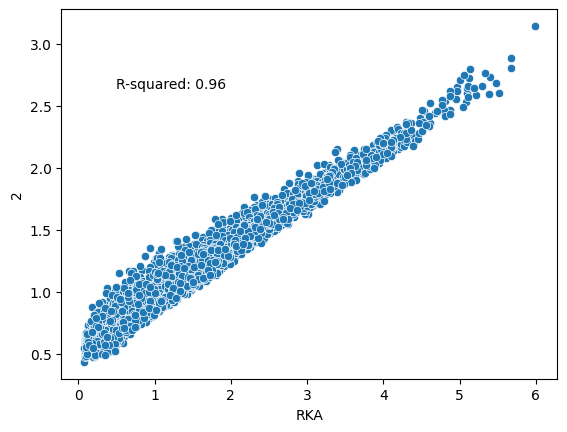

In [14]:
res = stats.linregress(plotdata.RKA.astype(float), plotdata.iloc[:,choose_col].astype(float))
sns.scatterplot(x=plotdata.RKA, y=plotdata.iloc[:,choose_col])
plt.text(0.5, plotdata.iloc[:,choose_col].max()-0.5, f"R-squared: {res.rvalue**2:.2f}", horizontalalignment='left', size='medium', color='black')


Text(-2, 0.645404260399632, 'R-squared: 0.87')

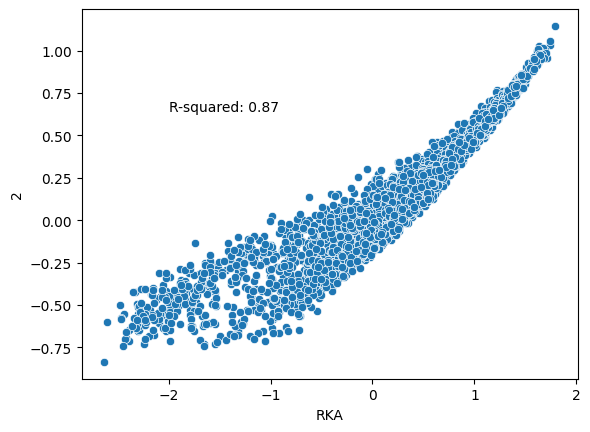

In [15]:
res_log = stats.linregress(np.log(plotdata.RKA.astype(float)),np.log(plotdata.iloc[:,choose_col].astype(float)))
sns.scatterplot(x=np.log(plotdata.RKA.astype(float)),y=np.log(plotdata.iloc[:,choose_col].astype(float)))
plt.text(-2, np.log(plotdata.iloc[:,choose_col].astype(float)).max()-0.5, f"R-squared: {res_log.rvalue**2:.2f}", horizontalalignment='left', size='medium', color='black')

### Interactive Plot

In [16]:
fig = px.scatter(plotdata, x='RKA', y='3', color='qc_x', custom_data=['id','RKA'])
                    
#set hover
fig.update_traces(
    hovertemplate = "<br>".join([
    "Sequence: %{customdata[0]}",
    "RKA: %{customdata[1]}"])
)
fig.show()

## Histogram

<Axes: xlabel='RKA', ylabel='Count'>

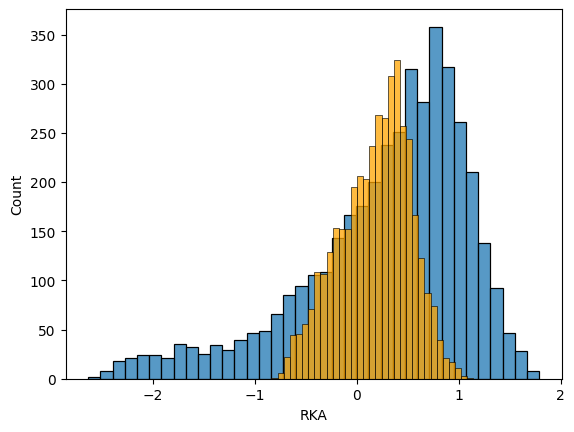

In [17]:
sns.histplot(np.log(plotdata.RKA.astype(float)))
sns.histplot(np.log(plotdata.iloc[:,choose_col].astype(float)), color="orange")